# data cleaning and exploration

a lot of ideas come from fourski1ng [github](https://github.com/foursking1/jd)

In [1]:
# -*- coding: UTF-8 -*-
import time
from datetime import datetime
from datetime import timedelta
import pandas as pd
import pickle
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

plt.style.use('ggplot')
%matplotlib inline

action_1_path = "./data/JData_Action_201602.csv"
action_2_path = "./data/JData_Action_201603.csv"
action_3_path = "./data/JData_Action_201604.csv"
comment_path = "./data/JData_Comment.csv"
product_path = "./data/JData_Product.csv"
user_path = "./data/JData_User.csv"

# user data

from jd

|user_id|用户ID|脱敏|
|-------|-----|-----|
|age|年龄段|-1表示未知|
|sex|性别|0表示男，1表示女，2表示保密|
|user_lv_cd|用户等级|有顺序的级别枚举，越高级别数字越大|
|user_reg_tm|用户注册日期|粒度到天|


In [2]:
user = pd.read_csv(user_path, encoding='gbk')
user.user_reg_tm = pd.to_datetime(user.user_reg_tm)
user.head(2)

,user_id,age,sex,user_lv_cd,user_reg_tm
0,200001,56岁以上,2.0,5,2016-01-26
1,200002,-1,0.0,1,2016-01-26


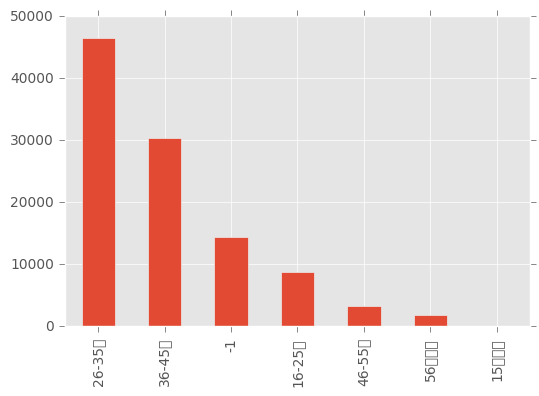

In [3]:
# age plot
user.age.value_counts().plot.bar()

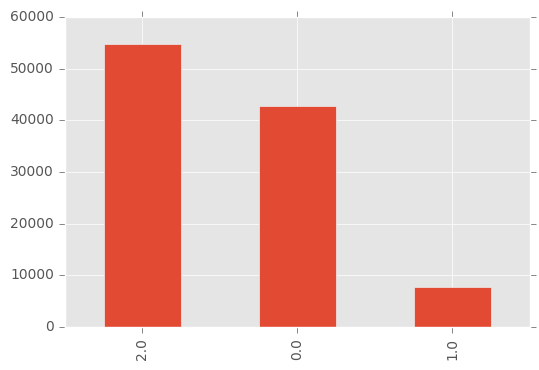

In [4]:
# sex plot
user.sex.value_counts().plot.bar()

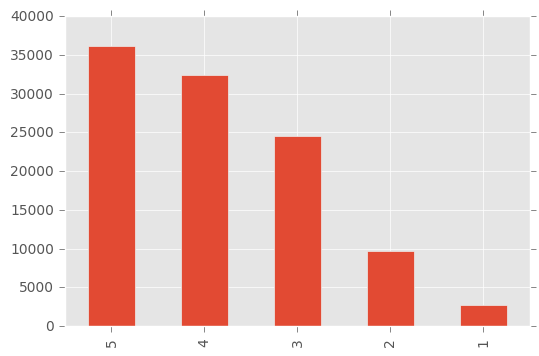

In [5]:
# level plot
user.user_lv_cd.value_counts().plot.bar()

In [6]:
# users that registered after the test period
test_date = datetime(2016, 4, 16)

user.user_reg_tm = pd.to_datetime(user.user_reg_tm)
user[user.user_reg_tm > test_date].head()

,user_id,age,sex,user_lv_cd,user_reg_tm
8545,208546,16-25岁,0.0,2,2016-04-29
9394,209395,16-25岁,1.0,2,2016-05-11
10362,210363,56岁以上,2.0,2,2016-05-24
10367,210368,-1,2.0,1,2016-05-24
11019,211020,36-45岁,2.0,3,2016-06-06


In [7]:
# select registed user before the test period
user_with_valid_reg_date = user[(user.user_reg_tm < test_date)]
user_with_valid_reg_date.user_reg_tm.describe()

count                  105309
unique                   3447
top       2015-11-11 00:00:00
freq                      412
first     2003-06-16 00:00:00
last      2016-04-15 00:00:00
Name: user_reg_tm, dtype: object

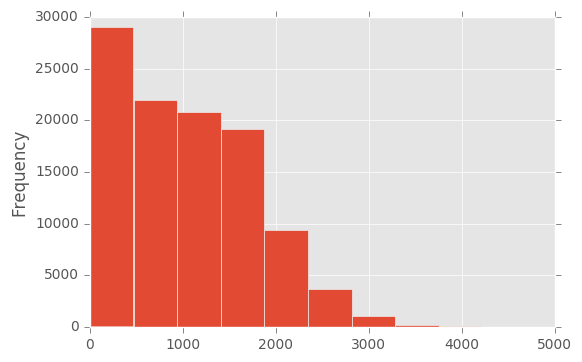

In [8]:
# the days customers registered at 2016-04-15

reg_days = user_with_valid_reg_date.user_reg_tm.map(lambda x:(test_date - x).days)
reg_days.plot.hist()

In [2]:
# ETL
def convert_age(age_str):
    if age_str == u'-1':
        return 0
    elif age_str == u'15岁以下':
        return 1
    elif age_str == u'16-25岁':
        return 2
    elif age_str == u'26-35岁':
        return 3
    elif age_str == u'36-45岁':
        return 4
    elif age_str == u'46-55岁':
        return 5
    elif age_str == u'56岁以上':
        return 6
    else:
        return -1

def get_basic_user_feat():
    dump_path = './cache/basic_user.pkl'
    if os.path.exists(dump_path):
        user_with_valid_reg_date = pickle.load(open(dump_path))
    else:
        user = pd.read_csv(user_path, encoding='gbk')
        user['age'] = user['age'].map(convert_age)
        age_df = pd.get_dummies(user["age"], prefix="age")
        sex_df = pd.get_dummies(user["sex"], prefix="sex")
        user_lv_df = pd.get_dummies(user["user_lv_cd"], prefix="user_lv_cd")
        user_mat = pd.concat([user[['user_id', 'user_reg_tm']], age_df, sex_df, user_lv_df], axis=1)
        
        user_mat.user_reg_tm = pd.to_datetime(user_mat.user_reg_tm)
        user_with_valid_reg_date = user_mat[(user_mat.user_reg_tm < test_date)]
        user_with_valid_reg_date['reg_days'] = user_with_valid_reg_date.user_reg_tm.map(lambda x:(test_date - x).days)
        # user_processed = user_with_valid_reg_date.drop('user_reg_tm', 1)
        
        pickle.dump(user_with_valid_reg_date, open(dump_path, 'w'))
    return user_with_valid_reg_date

In [3]:
test_date = datetime(2016, 4, 16)
user_tr = get_basic_user_feat()

# Product

商品数据

|sku_id|商品编号|脱敏|
|------|--------|----|
|a1|属性1|枚举，-1表示未知|
|a2|属性2|枚举，-1表示未知|
|a3|属性3|枚举，-1表示未知|
|cate|品类ID|脱敏|
|brand|品牌ID|脱敏|

In [14]:
product = pd.read_csv(product_path)
product.head()

,sku_id,a1,a2,a3,cate,brand
0,10,3,1,1,8,489
1,100002,3,2,2,8,489
2,100003,1,-1,-1,8,30
3,100006,1,2,1,8,545
4,10001,-1,1,2,8,244


only one category of products

In [15]:
# only testing cate8
product.cate.value_counts()

8    24187
Name: cate, dtype: int64

In [16]:
# brands with most products
product.groupby('brand').size().nlargest(10)

brand
489    6637
214    6444
623    1101
812    1061
800    1015
545     945
124     932
306     795
30      659
885     601
dtype: int64

In [23]:
# ETL
def get_basic_product_feat():
    dump_path = './cache/basic_product.pkl'
    if os.path.exists(dump_path):
         product = pickle.load(open(dump_path))
    else:
        product = pd.read_csv(product_path)
        attr1_df = pd.get_dummies(product["a1"], prefix="a1")
        attr2_df = pd.get_dummies(product["a2"], prefix="a2")
        attr3_df = pd.get_dummies(product["a3"], prefix="a3")
        product = pd.concat([product[['sku_id', 'cate', 'brand']], attr1_df, attr2_df, attr3_df], axis=1)
        pickle.dump(product, open(dump_path, 'w'))
    return product

In [24]:
product_tr = get_basic_product_feat()

In [25]:
product_tr.head()

,sku_id,cate,brand,a1_-1,a1_1,a1_2,a1_3,a2_-1,a2_1,a2_2,a3_-1,a3_1,a3_2
0,10,8,489,0,0,0,1,0,1,0,0,1,0
1,100002,8,489,0,0,0,1,0,0,1,0,0,1
2,100003,8,30,0,1,0,0,1,0,0,1,0,0
3,100006,8,545,0,1,0,0,0,0,1,0,1,0
4,10001,8,244,1,0,0,0,0,1,0,0,0,1


## attempt to cluster products

In [26]:
# Kmeans
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(5)

kmeans = KMeans(n_clusters=2, random_state=0).fit(product_tr)
labels = kmeans.labels_

In [27]:
product["label"] = labels
product.label.value_counts()

1    12150
0    12037
Name: label, dtype: int64

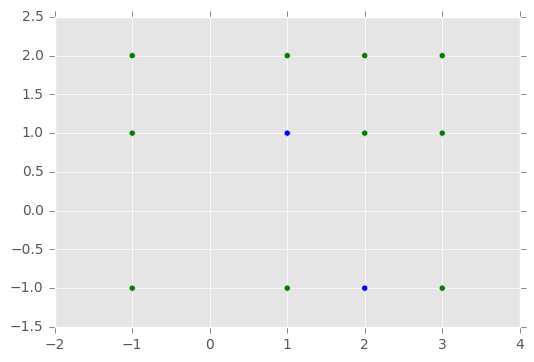

In [28]:
colors = ["b", "g", "r"]
product["color"] = product.label.map(lambda x: colors[x])

plt.scatter(product.a1, product.a2, c=product.color)

# Comment

评价数据

|Name|explaination|data|
|-|-|-|
|dt|  截止到时间|   粒度到天|
|sku_id|  商品编号|    脱敏|
|comment_num|累计评论数分段 |0表示无评论，1表示有1条评论，2表示有2-10条评论，3表示有11-50条评论，4表示大于50条评论|
|has_bad_comment|     是否有差评|   0表示无，1表示有|
|bad_comment_rate|    差评率|     差评数占总评论数的比重|

In [29]:
comments = pd.read_csv(comment_path)

In [30]:
comments.head()

,dt,sku_id,comment_num,has_bad_comment,bad_comment_rate
0,2016-02-01,1000,3,1,0.0417
1,2016-02-01,10000,2,0,0.0000
2,2016-02-01,100011,4,1,0.0376
3,2016-02-01,100018,3,0,0.0000
4,2016-02-01,100020,3,0,0.0000


In [31]:
# todo: ETL

# Action

|Name|explaination|data|
|-|-|-|
|user_id     |用户编号    |脱敏|
|sku_id  |商品编号    |脱敏|
|time    |行为时间    ||
|model_id    |点击模块编号，如果是点击    |脱敏|
|type |1.浏览（指浏览商品详情页）；2.加入购物车；3.购物车删除；4.下单；5.关注；6.点击 ||
|cate |   品类ID    |脱敏|
|brand   |品牌ID|

In [2]:
action_paths = [action_1_path, action_2_path, action_3_path]
action1, action2, action3 = [pd.read_csv(p) for p in action_paths]

In [3]:
action1.head()

,user_id,sku_id,time,model_id,type,cate,brand
0,266079.0,138778,2016-01-31 23:59:02,NaN,1,8,403
1,266079.0,138778,2016-01-31 23:59:03,0.0,6,8,403
2,200719.0,61226,2016-01-31 23:59:07,NaN,1,8,30
3,200719.0,61226,2016-01-31 23:59:08,0.0,6,8,30
4,263587.0,72348,2016-01-31 23:59:08,NaN,1,5,159


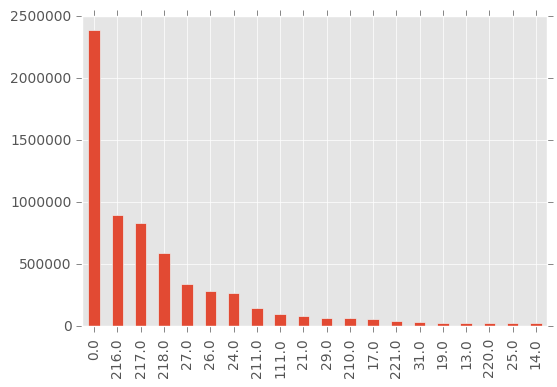

In [4]:
# about model id
action1.model_id.value_counts().nlargest(20).plot.bar()

In [5]:
# action counts
action1.type.value_counts()

6    6690425
1    4554840
2     140727
3      58917
5      29030
4      11485
Name: type, dtype: int64

In [6]:
# data available for cate 8 and others
action1.cate.value_counts()

8     3194275
4     2918671
6     1642371
5     1483361
7     1126849
9      888435
10     211572
11      19890
Name: cate, dtype: int64

In [7]:
action_all = pd.concat([action1, action2, action3])
pickle.dump(action_all, open('data/all_action', 'w'))

105180

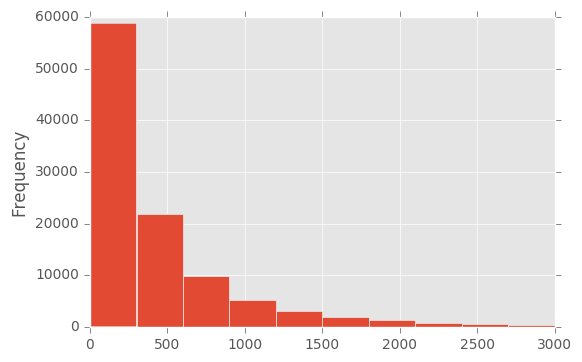

In [14]:
# 瞎逛
user_cate = action_all.groupby('user_id').cate
user_cate_count = user_cate.count()
user_cate_count_mainstream = user_cate_count[user_cate_count < 3000]
user_cate_count_mainstream.plot.hist()

In [16]:
"""Bots?"""
print user_cate_count.nlargest(20)
print "Total users", len(user_cate_count)


user_id
237793.0    22056
271592.0    20194
255920.0    19317
296877.0    19048
238543.0    18956
229662.0    18211
200118.0    16435
212090.0    16415
207081.0    16148
222248.0    16013
290880.0    15919
290470.0    14977
279524.0    14850
205793.0    14573
269325.0    14195
265648.0    14154
250141.0    13751
229558.0    13552
211730.0    12664
209445.0    12619
Name: cate, dtype: int64
Total users 105180


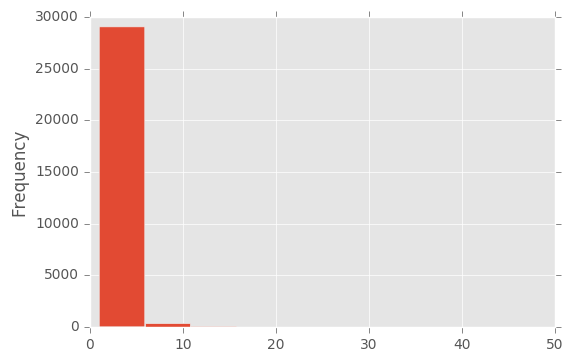

In [23]:
# 剁手
duoshou = action_all[action_all['type'] == 4]
user_duoshou_count = duoshou.groupby('user_id').time.count()
user_duoshou_count.plot.hist()

user_id
294834.0    50
202597.0    39
292996.0    38
290054.0    32
293252.0    32
281255.0    31
242497.0    29
242867.0    28
296731.0    27
200213.0    26
253777.0    26
243989.0    24
276851.0    24
202183.0    23
280742.0    23
288782.0    23
228187.0    22
295413.0    22
200092.0    21
214106.0    21
Name: time, dtype: int64

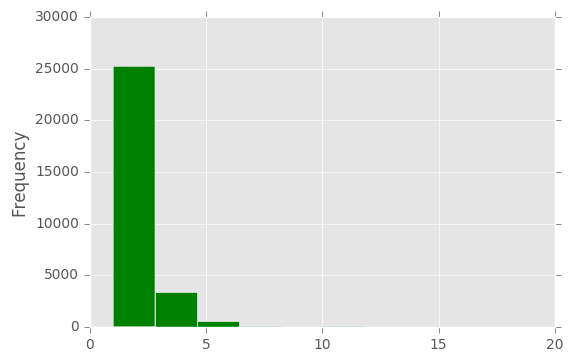

In [22]:
user_duoshou_mainstream = user_duoshou_count[user_duoshou_count < 20]
user_duoshou_mainstream.plot.hist(fc='green')
len(user_duoshou_count)
user_duoshou_count.nlargest(20)

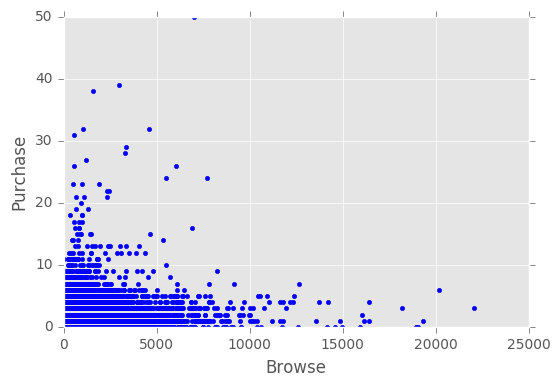

In [36]:
# 剁手 vs 瞎逛

joint_duoshou_cate = pd.DataFrame({'browse': user_cate_count, 'purchase': user_duoshou_count})
joint_duoshou_cate[pd.isnull(joint_duoshou_cate)] = 0.0
plt.plot(joint_duoshou_cate['browse'], joint_duoshou_cate['purchase'], 'b.')
plt.xlabel('Browse')
plt.ylabel('Purchase')

# dump the data processed

In [39]:
dump_folder = "./data"
processed_data = [user_tr, product_tr]
processed_data_name = ["users", "products"]

for data, data_name in zip(processed_data, processed_data_name):
    pickle.dump(data, open(os.path.join(dump_folder, data_name), 'w'))

# Wei's proposal of processing action data 
Assume whether a user will buy cate8 product depends on his basic account info plus his purchase history. <br />
Onehot encoding by the type of action on the category of the product. <br />
Then divide the action by time windows, currently select the window of 5 days, since the prediction is about 5 days (0416-0420)

In [4]:
def get_action_feature_by_user(action_all,start_date,end_date):
    dump_path='./cache/basic_action_feat_%s_%s.pkl' % (start_date,end_date)
    if os.path.exists(dump_path):
        action_timeRange=pickle.load(open(dump_path))
    else:
        action_timeRange=action_all[(action_all.time>start_date) & (action_all.time<=end_date)]
        action_timeRange_onehot_type=pd.get_dummies(action_timeRange['type'],prefix='act_type')
        action_timeRange_onehot_cate=pd.get_dummies(action_timeRange['cate'],prefix='cate')
        action_timeRange_onehot_mix=pd.DataFrame()
        for i in action_timeRange_onehot_type.columns:
            for j in action_timeRange_onehot_cate.columns:
                action_timeRange_onehot_mix[i+'_'+j+'_'+start_date+'_'+end_date]=\
                action_timeRange_onehot_type[i]*action_timeRange_onehot_cate[j]
        # ! do not convert the onehot dataframe to sparse, cause the group action on sparse dataframe is extremely slow
        # too many brands/model_id categories and ~40% of mode_id are NaN, therefore ditch these two features,
        # for predicting if will buy cate8 anyway
        action_timeRange=pd.concat((action_timeRange.user_id,action_timeRange_onehot_mix),axis=1)
        #days_fromStart=action_timeRange.time.map(lambda x: (datetime.strptime(x,'%Y-%m-%d %H:%M:%S')\
        #                                                    -datetime.strptime(start_date,'%Y-%m-%d')).days)
        #days_fromEnd=action_timeRange.time.map(lambda x: (datetime.strptime(end_date,'%Y-%m-%d')-\
        #                                                  datetime.strptime(x,'%Y-%m-%d %H:%M:%S')).days)
        # additional features: actions weighted by reverse of the days, and negative exponential of the days
        # though recent actions might seem to indicate more heavily on the users' behaviour
        # recent purcahse could also indicate the users do not need to buy them anytime soon
        # Therefore, we have 'rev_recent', 'exp_recent' as well as 'rev_oldest', 'exp_oldest'

        # Not adding the inverse features to speed up the groupby process
        #tempFeat=action_timeRange_onehot_mix.copy()
        #for feat in tempFeat.columns:
        #    tempFeat[feat]=tempFeat[feat]/(days_fromEnd+1)
        #tempFeat.columns+='_inv_recent'
        #action_timeRange=pd.concat((action_timeRange,tempFeat),axis=1)

        #tempFeat=action_timeRange_onehot_mix.copy()
        #for feat in tempFeat.columns:
        #    tempFeat[feat]=tempFeat[feat]/(days_fromStart+1)
        #tempFeat.columns+='_inv_oldest'
        #action_timeRange=pd.concat((action_timeRange,tempFeat),axis=1)

        #expWeight_recent=days_fromEnd.map(lambda x: math.exp(-x/15)) # not to decay too quickly
        #expWeight_oldest=days_fromStart.map(lambda x: math.exp(-x/15))

        #tempFeat=action_timeRange_onehot_mix.copy()
        #for feat in tempFeat.columns:
        #    tempFeat[feat]=tempFeat[feat]*expWeight_recent
        #tempFeat.columns+='_exp_recent'
        #action_timeRange=pd.concat((action_timeRange,tempFeat),axis=1)

        #tempFeat=action_timeRange_onehot_mix.copy()
        #for feat in tempFeat.columns:
        #    tempFeat[feat]=tempFeat[feat]*expWeight_oldest
        #tempFeat.columns+='_exp_oldest'
        #action_timeRange=pd.concat((action_timeRange,tempFeat),axis=1)
        #action_timeRange=action_timeRange.drop('time',axis=1)
        action_timeRange=action_timeRange.groupby('user_id',axis=0,as_index=False).sum()
        pickle.dump(action_timeRange, open(dump_path,'w'))
    return action_timeRange

In [5]:
def partition_date_range(start_date,end_date,tWindowSize,direction='backwards'):
    if direction!='backwards':
        print 'Error: partition in forward direction is not implemented yet'
    else:
        start_date=datetime.strptime(start_date,'%Y-%m-%d')
        end_date=datetime.strptime(end_date,'%Y-%m-%d')
        intervals=math.ceil((end_date-start_date).days/tWindowSize)
        for i in range(int(intervals)):
            yield (end_date-timedelta(days=tWindowSize*i)).strftime('%Y-%m-%d')
        yield start_date.strftime('%Y-%m-%d')

In [6]:
def partition_action_feature_time_window(user_feature,action_all,start_date,end_date,tWindowSize):
    timeList=list(partition_date_range(start_date,end_date,tWindowSize))
    timeList.reverse()
    actionFeat_by_window=user_feature
    for i in range(len(timeList)-1):
        tempActionFeat=get_action_feature_by_user(action_all,timeList[i],timeList[i+1])
        actionFeat_by_window=actionFeat_by_window.merge(tempActionFeat,how='left',on='user_id').fillna(0)
    return actionFeat_by_window

In [7]:
action_paths = [action_1_path, action_2_path, action_3_path]
action1, action2, action3 = [pd.read_csv(p) for p in action_paths]
action_all = pd.concat([action1, action2, action3])

In [8]:
# must get basic user feature in advance
actionFeat_by_window=partition_action_feature_time_window(user_tr,action_all,'2016-01-31','2016-04-15',5)

In [9]:
# to save memory
action1=None
action2=None
action3=None
action_all=None

In [10]:
actionFeat_by_window.head(3)

,user_id,user_reg_tm,age_-1,age_0,age_1,age_2,age_3,age_4,age_5,age_6,...,act_type_5_cate_10_2016-04-10_2016-04-15,act_type_5_cate_11_2016-04-10_2016-04-15,act_type_6_cate_4_2016-04-10_2016-04-15,act_type_6_cate_5_2016-04-10_2016-04-15,act_type_6_cate_6_2016-04-10_2016-04-15,act_type_6_cate_7_2016-04-10_2016-04-15,act_type_6_cate_8_2016-04-10_2016-04-15,act_type_6_cate_9_2016-04-10_2016-04-15,act_type_6_cate_10_2016-04-10_2016-04-15,act_type_6_cate_11_2016-04-10_2016-04-15
0,200001,2016-01-26,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200002,2016-01-26,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,0.0
2,200003,2016-01-26,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0


In [11]:
# split train, test set (70%, 30%), to get a sense how accurate the prediction of whether to purchase cate8 will be
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(actionFeat_by_window,test_size=0.3)

In [12]:
def get_label(actionFeat_by_window,start_date,end_date):
    label=(actionFeat_by_window['act_type_4_cate_8'+'_'+start_date+'_'+end_date]>0).astype(int)
    return label

In [14]:
train_label=get_label(train_set,'2016-04-10', '2016-04-15')
train_label.sum()/train_label.count()

0.012046231482988768

In [14]:
train_label.sum()

888

In [15]:
test_label=get_label(test_set,'2016-04-10', '2016-04-15')
test_label.sum()/test_label.count()

0.011584844744088881

In [15]:
# skewed data, cannot just use accuracy as evaluation score
def JD_custom_score_func(label,prediction):
    Precise=np.sum(label*prediction)/np.sum(prediction)
    Recall=np.sum(label*prediction)/np.sum(label)
    F11=6*Recall*Precise/(5*Recall+Precise)
    F12=5*Recall*Precise/(2*Recall+3*Precise)
    Score=0.4*F11 + 0.6*F12
    return Score

In [16]:
from sklearn.metrics import make_scorer
JDcustomScorer=make_scorer(JD_custom_score_func, greater_is_better=True)

In [42]:
%reset_selective JDcustomScorer

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [43]:
%reset_selective customScorer.py

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [16]:
# https://github.com/scikit-learn/scikit-learn/issues/2889
from customScorer import JDcustomScorer

In [17]:
type(JDcustomScorer)

sklearn.metrics.scorer._PredictScorer

In [18]:
train_data=train_set.drop(list(train_set.filter(regex='2016-04-10_2016-04-15$',axis=1).columns)+['user_id','user_reg_tm'],axis=1)

In [19]:
train_data.describe()

,age_-1,age_0,age_1,age_2,age_3,age_4,age_5,age_6,sex_0.0,sex_1.0,...,act_type_5_cate_10_2016-04-05_2016-04-10,act_type_5_cate_11_2016-04-05_2016-04-10,act_type_6_cate_4_2016-04-05_2016-04-10,act_type_6_cate_5_2016-04-05_2016-04-10,act_type_6_cate_6_2016-04-05_2016-04-10,act_type_6_cate_7_2016-04-05_2016-04-10,act_type_6_cate_8_2016-04-05_2016-04-10,act_type_6_cate_9_2016-04-05_2016-04-10,act_type_6_cate_10_2016-04-05_2016-04-10,act_type_6_cate_11_2016-04-05_2016-04-10
count,73716.0,73716.000000,73716.000000,73716.000000,73716.000000,73716.000000,73716.000000,73716.000000,73716.000000,73716.000000,...,73716.000000,73716.0,73716.000000,73716.00000,73716.000000,73716.000000,73716.000000,73716.000000,73716.000000,73716.000000
mean,0.0,0.136985,0.000068,0.083171,0.442753,0.288201,0.031540,0.017283,0.405434,0.073525,...,0.000421,0.0,5.592558,2.44624,3.108986,1.930083,11.021542,1.865552,0.221838,0.047222
std,0.0,0.343834,0.008236,0.276142,0.496715,0.452928,0.174773,0.130323,0.490979,0.260999,...,0.030592,0.0,35.132037,18.03320,23.037652,19.315288,39.290858,21.530325,4.701863,0.519035
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,0.0,2468.000000,1172.00000,2032.000000,1786.000000,2292.000000,1926.000000,726.000000,22.000000


In [20]:
# normalization
actionFeat_by_window_mean=actionFeat_by_window.drop(list(train_set.filter(regex='2016-04-10_2016-04-15$',axis=1).columns)+['user_id','user_reg_tm'],axis=1).mean()
actionFeat_by_window_std=actionFeat_by_window.drop(list(train_set.filter(regex='2016-04-10_2016-04-15$',axis=1).columns)+['user_id','user_reg_tm'],axis=1).std()

train_data=(train_data-actionFeat_by_window_mean)/actionFeat_by_window_std

In [21]:
train_data.head()

,age_-1,age_0,age_1,age_2,age_3,age_4,age_5,age_6,sex_0.0,sex_1.0,...,act_type_5_cate_10_2016-04-05_2016-04-10,act_type_5_cate_11_2016-04-05_2016-04-10,act_type_6_cate_4_2016-04-05_2016-04-10,act_type_6_cate_5_2016-04-05_2016-04-10,act_type_6_cate_6_2016-04-05_2016-04-10,act_type_6_cate_7_2016-04-05_2016-04-10,act_type_6_cate_8_2016-04-05_2016-04-10,act_type_6_cate_9_2016-04-05_2016-04-10,act_type_6_cate_10_2016-04-05_2016-04-10,act_type_6_cate_11_2016-04-05_2016-04-10
20220,NaN,-0.398153,-0.008153,-0.301852,-0.890388,1.572140,-0.180563,-0.134455,-0.828196,-0.281573,...,-0.015184,NaN,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
42024,NaN,-0.398153,-0.008153,-0.301852,-0.890388,1.572140,-0.180563,-0.134455,-0.828196,-0.281573,...,-0.015184,NaN,-0.016710,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
20788,NaN,-0.398153,-0.008153,-0.301852,1.123095,-0.636069,-0.180563,-0.134455,-0.828196,-0.281573,...,-0.015184,NaN,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
73205,NaN,2.511571,-0.008153,-0.301852,-0.890388,-0.636069,-0.180563,-0.134455,-0.828196,-0.281573,...,-0.015184,NaN,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
37813,NaN,2.511571,-0.008153,-0.301852,-0.890388,-0.636069,-0.180563,-0.134455,1.207432,-0.281573,...,-0.015184,NaN,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452


In [22]:
#age_-1 contant 0, meaning, all users have age info, drop
train_data=train_data.drop('age_-1',axis=1)

In [22]:
train_data.columns[(train_data.isnull().sum()>0)]

Index([u'act_type_3_cate_11_2016-01-31_2016-02-05',
       u'act_type_5_cate_11_2016-01-31_2016-02-05',
       u'act_type_3_cate_11_2016-02-05_2016-02-10',
       u'act_type_4_cate_11_2016-02-05_2016-02-10',
       u'act_type_5_cate_11_2016-02-05_2016-02-10',
       u'act_type_3_cate_11_2016-02-10_2016-02-15',
       u'act_type_3_cate_11_2016-02-15_2016-02-20',
       u'act_type_5_cate_11_2016-02-15_2016-02-20',
       u'act_type_3_cate_11_2016-02-20_2016-02-25',
       u'act_type_3_cate_11_2016-02-25_2016-03-01',
       u'act_type_4_cate_11_2016-02-25_2016-03-01',
       u'act_type_5_cate_11_2016-02-25_2016-03-01',
       u'act_type_3_cate_11_2016-03-01_2016-03-06',
       u'act_type_3_cate_11_2016-03-06_2016-03-11',
       u'act_type_3_cate_11_2016-03-11_2016-03-16',
       u'act_type_4_cate_11_2016-03-11_2016-03-16',
       u'act_type_3_cate_11_2016-03-16_2016-03-21',
       u'act_type_5_cate_11_2016-03-16_2016-03-21',
       u'act_type_3_cate_11_2016-03-21_2016-03-26',
       u'act

In [23]:
# it seems often actions related to cate11 are contant 0, maybe to account cate11 as a trivia cate and exclude it?
# fillna with 0 for now.
train_data=train_data.fillna(0)

In [24]:
train_data.head(5)

,age_0,age_1,age_2,age_3,age_4,age_5,age_6,sex_0.0,sex_1.0,sex_2.0,...,act_type_5_cate_10_2016-04-05_2016-04-10,act_type_5_cate_11_2016-04-05_2016-04-10,act_type_6_cate_4_2016-04-05_2016-04-10,act_type_6_cate_5_2016-04-05_2016-04-10,act_type_6_cate_6_2016-04-05_2016-04-10,act_type_6_cate_7_2016-04-05_2016-04-10,act_type_6_cate_8_2016-04-05_2016-04-10,act_type_6_cate_9_2016-04-05_2016-04-10,act_type_6_cate_10_2016-04-05_2016-04-10,act_type_6_cate_11_2016-04-05_2016-04-10
20220,-0.398153,-0.008153,-0.301852,-0.890388,1.572140,-0.180563,-0.134455,-0.828196,-0.281573,0.961362,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
42024,-0.398153,-0.008153,-0.301852,-0.890388,1.572140,-0.180563,-0.134455,-0.828196,-0.281573,0.961362,...,-0.015184,0.0,-0.016710,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
20788,-0.398153,-0.008153,-0.301852,1.123095,-0.636069,-0.180563,-0.134455,-0.828196,-0.281573,0.961362,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
73205,2.511571,-0.008153,-0.301852,-0.890388,-0.636069,-0.180563,-0.134455,-0.828196,-0.281573,0.961362,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
37813,2.511571,-0.008153,-0.301852,-0.890388,-0.636069,-0.180563,-0.134455,1.207432,-0.281573,-1.040181,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452


In [25]:
# define log uniform distribution, useful when use RandomizedSearchCV to search hyperparameters
from scipy.stats import rv_continuous
from scipy.stats import uniform
class logUniform(rv_continuous):
    'Log Uniform distribution'
    def _pdf(self,x,p,q):
        if x>=np.exp(p) and x<=np.exp(q):
            return 1.0/((q-p)*x)
        else:
            return 0
    def _rvs(self,p,q): # important to explicitly define the _RVS, otherwise extremely slow
        size=self._size
        #print args
        loc=p
        scale=q-p
        return np.exp(uniform.rvs(loc=loc,scale=scale,size=size)) 
    def _argcheck(self,p,q):
        return True
myLogUniform=logUniform(a=0)

In [26]:
myLogUniform(p=0,q=1).rvs(size=10)

array([ 1.7028032 ,  1.07724127,  2.48154845,  2.36380467,  2.48471607,
        1.78229864,  1.72598892,  1.09427489,  1.90765418,  1.34994037])

In [27]:
test_data=test_set.drop(list(test_set.filter(regex='2016-04-10_2016-04-15$',axis=1).columns)+['user_id','user_reg_tm'],axis=1)

In [28]:
test_data=(test_data-actionFeat_by_window_mean)/actionFeat_by_window_std
test_data=test_data.drop('age_-1',axis=1)
test_data=test_data.fillna(0)

In [29]:
test_data.head()

,age_0,age_1,age_2,age_3,age_4,age_5,age_6,sex_0.0,sex_1.0,sex_2.0,...,act_type_5_cate_10_2016-04-05_2016-04-10,act_type_5_cate_11_2016-04-05_2016-04-10,act_type_6_cate_4_2016-04-05_2016-04-10,act_type_6_cate_5_2016-04-05_2016-04-10,act_type_6_cate_6_2016-04-05_2016-04-10,act_type_6_cate_7_2016-04-05_2016-04-10,act_type_6_cate_8_2016-04-05_2016-04-10,act_type_6_cate_9_2016-04-05_2016-04-10,act_type_6_cate_10_2016-04-05_2016-04-10,act_type_6_cate_11_2016-04-05_2016-04-10
13477,-0.398153,-0.008153,-0.301852,1.123095,-0.636069,-0.180563,-0.134455,-0.828196,-0.281573,0.961362,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
17481,-0.398153,-0.008153,-0.301852,1.123095,-0.636069,-0.180563,-0.134455,-0.828196,-0.281573,0.961362,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,1.634471,-0.087069,-0.049353,-0.089452
27240,-0.398153,-0.008153,-0.301852,-0.890388,1.572140,-0.180563,-0.134455,1.207432,-0.281573,-1.040181,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.128609,-0.087069,-0.049353,-0.089452
103716,-0.398153,-0.008153,-0.301852,1.123095,-0.636069,-0.180563,-0.134455,-0.828196,3.551440,-1.040181,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452
4472,2.511571,-0.008153,-0.301852,-0.890388,-0.636069,-0.180563,-0.134455,-0.828196,-0.281573,0.961362,...,-0.015184,0.0,-0.163342,-0.129566,-0.135541,-0.103607,-0.279731,-0.087069,-0.049353,-0.089452


In [43]:
# http://fastml.com/what-is-better-gradient-boosted-trees-or-random-forest/
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
clf=RandomForestClassifier()
param_dist={'n_estimators':randint(20,50),'min_samples_leaf':randint(1,4),'criterion':['gini', 'entropy'],'max_features':['sqrt','log2',None],\
            'class_weight':[{0:1,1:x} for x in np.logspace(0,2,20)]}
t0=time.time()
clf_randomCV=RandomizedSearchCV(clf,param_distributions=param_dist,n_iter=100,scoring=JDcustomScorer,cv=3,n_jobs=-1)
clf_randomCV.fit(train_data.as_matrix(),train_label.as_matrix())
print time.time()-t0

4672.74099994


In [44]:
clf_randomCV.best_score_

0.20775446775711062

In [45]:
clf_randomCV.best_params_

{'class_weight': {0: 1, 1: 18.329807108324356},
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'n_estimators': 40}

In [35]:
test_predict=clf_randomCV.predict(test_data.as_matrix())

In [36]:
test_predict.sum()

667

In [46]:
train_predict=clf_randomCV.predict(train_data)

In [47]:
train_predict.sum()

1956

In [48]:
train_label.sum()

888

In [49]:
(train_predict==train_label).sum()/len(train_label)

0.98119811167182158

In [46]:
test_label.sum()

375

In [40]:
from customScorer import JD_custom_score_func

In [50]:
JD_custom_score_func(train_label,train_predict)

0.49403094193086011

In [51]:
JD_custom_score_func(test_label,test_predict)

0.16461029518955522